<a href="https://colab.research.google.com/github/leonbenenati/Projeto/blob/main/Previs%C3%A3o_de_taxa_de_juros_com_Arima_e_modelos_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo desse projeto é prever a taxa de juros de longo prazo, será utilizado a taxa de juros LTN de 12 meses com dados diários. Os dados estão diponiveis no ipeadata (http://www.ipeadata.gov.br/Default.aspx)

Na primeira parte será utilizado o modelo Arima e na segunda parte os modelos de machine learning


# Importação de dados e ajustes iniciais 

In [453]:
#Importando pacotes 
import pandas as pd
import numpy as np


In [454]:
#carregando os dados
df = pd.read_csv('/content/ipeadata[02-10-2021-01-51].csv',sep=";",index_col="Data")

In [455]:
#verificando os dados
df.head()

,Taxa de juros prefixada - estrutura a termo - LTN - 12 meses - (% a.a.) - Associação Brasileira das Entidades dos Mercados Financeiro e de Capitais (Anbima) - ANBIMA366_TJTLN12366
Data,
01/01/2017,"11,5018"
02/01/2017,"11,5016"
03/01/2017,"11,3985"
04/01/2017,"11,424"
05/01/2017,"11,4087"


In [456]:
#Renomeando a coluna com os dados
df=df.rename(columns={"Taxa de juros prefixada - estrutura a termo - LTN - 12 meses - (% a.a.) - Associação Brasileira das Entidades dos Mercados Financeiro e de Capitais (Anbima) - ANBIMA366_TJTLN12366": "taxa"})

In [457]:
# Não há dados nos finais de semana então as linhas com dados faltantes será dropada
df.dropna(inplace=True)

In [458]:
#verificando se há dados faltantes 
df.isnull().sum()

taxa    0
dtype: int64

In [460]:
#Verificando os dados finais
df.tail(n=10)

,taxa
Data,
17/09/2021,"8,8144"
20/09/2021,"8,7884"
21/09/2021,"8,6738"
22/09/2021,"8,6574"
23/09/2021,"8,7311"
24/09/2021,"8,7812"
27/09/2021,"8,8486"
28/09/2021,"8,9518"
29/09/2021,"8,9135"


In [461]:
df.dtypes

taxa    object
dtype: object

In [462]:
#Mudando os dados para Float
columns = ["taxa"] 

df[columns] = df[columns].apply(lambda x: x.str.replace(',', '.').astype('float'))

In [463]:
df.dtypes

taxa    float64
dtype: object

In [464]:
print(df)

               taxa
Data               
01/01/2017  11.5018
02/01/2017  11.5016
03/01/2017  11.3985
04/01/2017  11.4240
05/01/2017  11.4087
...             ...
24/09/2021   8.7812
27/09/2021   8.8486
28/09/2021   8.9518
29/09/2021   8.9135
30/09/2021   8.9648

[1367 rows x 1 columns]


# Análise exploratória 

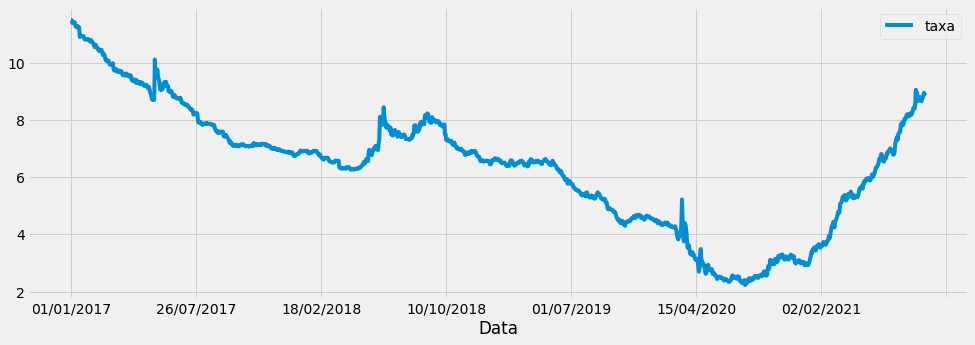

In [465]:
#Plotando o gráfico dos dados 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
ax = df.plot(figsize=(15, 5))
plt.show()

In [466]:
from statsmodels.tsa.stattools import adfuller


In [467]:
#O Teste de Dickey-Fuller aumentado é  necessário para verificar se a serie é estacionária, é necessário a estacionariedade para a previsão correta 
teste = adfuller(df['taxa'])
print(teste)




(-1.646124995327863, 0.45906212983852973, 18, 1348, {'1%': -3.435210382964628, '5%': -2.8636864858936333, '10%': -2.5679127921571907}, -2590.1115617972036)


In [468]:
#O P valor é muito alto a série não é estacionária pelo teste. Pelo gráfico já dava para notar a não estacionáriedade da série.
print(f' teste ADF:{teste[0]}')
print(f' p-valor:{teste[1]}')

 teste ADF:-1.646124995327863
 p-valor:0.45906212983852973


In [469]:
#Tirando a primeira diferença para deixar a série estacionária 
df_stationary = df.diff().dropna()

In [470]:
#Refazendo o Teste de Dickey-Fuller. A série está estacionária  
teste2 = adfuller(df_stationary['taxa'])
print(f' teste ADF:{teste2[0]}')
print(f' p-valor:{teste2[1]}')


 teste ADF:-5.86355492999542
 p-valor:3.3663714392616746e-07


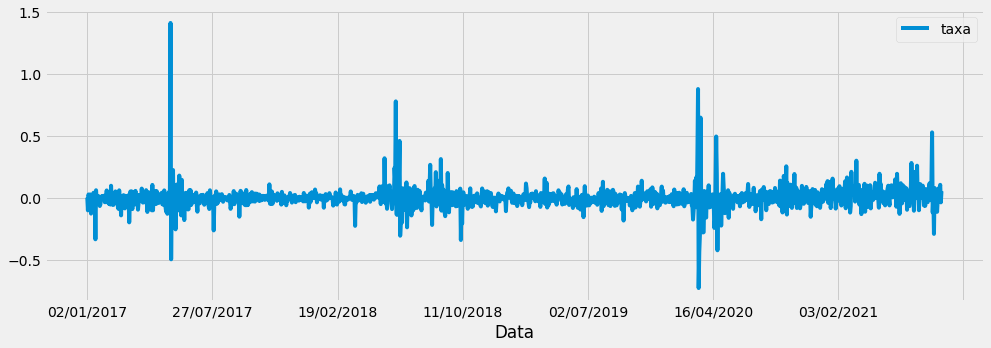

In [471]:
#Pelo Gráfico observamos que realmente a série esta estacionária 
ax = df_stationary.plot(figsize=(15, 5))
plt.show()

In [479]:
#Importando os modelos para verificar os componentes MA e AR 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


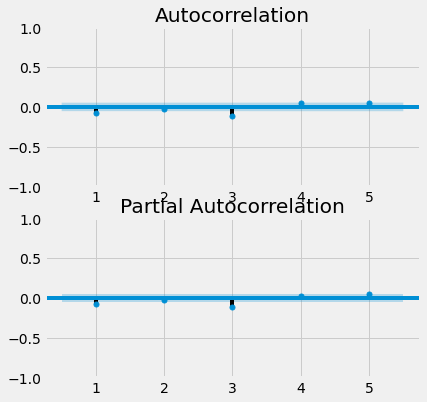

In [481]:
#Verificando os componentes MA e AR, tanto a auto correlação e a autocorrelação parcial demoram 2 processos.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6))

plot_acf(df_stationary['taxa'], lags=5, zero=False, ax=ax1)

plot_pacf(df_stationary['taxa'], lags=5, zero=False, ax=ax2)

plt.show()

 o modelo ARIMA precisa das variaveis P,D Q

 o D é quando a série é estacionária que no caso é 1

 o P e Q são calculados com o teste de raiz unitária que foi feito anteriomente

 Então temos um ARIMA(2,1,2)

 A seguir será utilizado o pacote auto_arima para calcular os melhores componentes do SARIMAX automaticamente, que utiliza PDQ

# Ajustando modelo SARIMAX

In [410]:
import statsmodels as sm

In [411]:
from statsmodels import api as sm

In [412]:
!pip install pmdarima


In [413]:
#Funcção para calcular o auto arima
import pmdarima as pm

def arimamodel(timeseriesarray):
    autoarima_model = pm.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              max_p=2, 
                              max_q=2,
                              d=1,
                              D=1,
                              trace=True)
    return autoarima_model


In [414]:
arima= arimamodel(df)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2602.365, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2593.296, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2599.405, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2600.062, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2594.757, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2600.870, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2600.707, Time=1.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2600.363, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2598.749, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2605.165, Time=2.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-2606.453, Time=1.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2601.941, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2602.101, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2603.607, Time=0.41 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1367
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1308.227
Date:                Tue, 05 Oct 2021   AIC                          -2606.453
Time:                        22:12:42   BIC                          -2580.355
Sample:                             0   HQIC                         -2596.685
                               - 1367                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4886      0.150     -3.262      0.001      -0.782      -0.195
ar.L2          0.4536      0.131      3.474      0.001       0.198       0.709
ma.L1          0.3950      0.149      2.659      0.008       0.104       0.686
ma.L2         -0.5131      0.124     -4.154      0.000      -0.755      -0.271
sigma2         0.0086   6.71e-05    128.116      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):            172056.87
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             3.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O autorima chegou no ARIMA(2,1,2)(0,0,0)[0], o Arima(2,1,2) foi o mesmo quando feito os testes 

Agora será ajustado o modelo

In [415]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [416]:
modelo = SARIMAX(df,order=(2,1,2), seasonal_order=(0,0,0,0))
modelo_sarima = modelo.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:599: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local

In [417]:
modelo_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   taxa   No. Observations:                 1367
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1308.227
Date:                Tue, 05 Oct 2021   AIC                          -2606.453
Time:                        22:12:43   BIC                          -2580.355
Sample:                             0   HQIC                         -2596.685
                               - 1367                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4886      0.150     -3.262      0.001      -0.782      -0.195
ar.L2          0.4536      0.131      3.474      0.001       0.198       0.709
ma.L1          0.3950      0.149      2.659      0.008       0.104       0.686
ma.L2         -0.5131      0.124     -4.154      0.000      -0.755      -0.271
sigma2         0.0086   6.71e-05    128.116      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):            172056.87
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             3.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Vericando erro do modelo escolhido SARIMAX

In [418]:
#Realizando a previsão iniciando 90 dias antes
pred = modelo_sarima.get_prediction(start=-90)
pred_media = pred.predicted_mean
pred_media.value_counts().sum()

90

In [419]:
#Calculando o erro ao quadrado 
from sklearn.metrics import mean_squared_error
from math import sqrt

mse_sarima = sqrt(mean_squared_error(df[-90:].values,pred_media.values))
print(mse_sarima)

0.10580104179989924


In [420]:
#Calculando o erro absoluto em porcentagem
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_sarima=mean_absolute_percentage_error(df[-90:].values,pred_media.values)
print(mape_sarima)

14.741022660787012


# Rezaliando Previsão com o modelo SARIMAX

In [421]:
#Realizando a previsão para 30
forecast = modelo_sarima.get_forecast(steps=30)
forecast_media = forecast.predicted_mean
forecast_media.values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


array([8.966193  , 8.95612702, 8.96167748, 8.95439954, 8.96047342,
       8.95420432, 8.96002266, 8.95433604, 8.95975384, 8.95452713,
       8.95953854, 8.95471902, 8.95934711, 8.95489959, 8.95917205,
       8.95506704, 8.95901083, 8.95522177, 8.95886209, 8.95536463,
       8.95872482, 8.95549651, 8.95859811, 8.95561824, 8.95848116,
       8.9557306 , 8.9583732 , 8.95583432, 8.95827356, 8.95593005])

In [422]:
#Intervalo de confiança 
intervalo_confiaca = forecast.conf_int()
limites_inferior = intervalo_confiaca.iloc[:,0]
limites_superior = intervalo_confiaca.iloc[:,1]


limites_inferior.values, limites_superior.values

(array([8.78444839, 8.71084542, 8.66760225, 8.62163978, 8.59220719,
        8.55510572, 8.53127168, 8.49893983, 8.47826773, 8.44916455,
        8.43059137, 8.40392579, 8.38686844, 8.3621531 , 8.3462471 ,
        8.32314854, 8.30814805, 8.28642292, 8.27215379, 8.25161647,
        8.23795104, 8.2184552 , 8.20529737, 8.18672472, 8.17400059,
        8.1562535 , 8.14390523, 8.12690177, 8.11488343, 8.09855388]),
 array([9.14793762, 9.20140863, 9.25575271, 9.2871593 , 9.32873965,
        9.35330293, 9.38877364, 9.40973225, 9.44123996, 9.45988972,
        9.48848571, 9.50551224, 9.53182579, 9.54764608, 9.572097  ,
        9.58698553, 9.60987361, 9.62402062, 9.64557039, 9.6591128 ,
        9.67949859, 9.69253782, 9.71189885, 9.72451176, 9.74296172,
        9.75520771, 9.77284117, 9.78476687, 9.80166369, 9.81330623]))

In [423]:
datas_forecast = np.asarray(forecast_media.index)
datas = np.asarray(df.index)

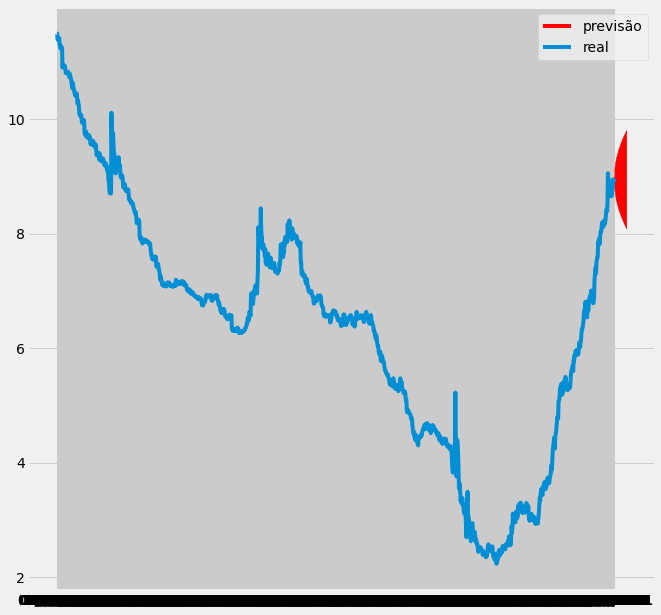

In [424]:
#Gráfico da previsão
plt.figure(figsize=(10,10))
plt.plot(datas_forecast,forecast_media.values,color='red',label='previsão')
plt.fill_between(datas_forecast, limites_inferior, limites_superior, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

# Utlizando modelos de Machine learning 

Para utilizar os modelos de ML será preciso criar as variáveis
Será criado a variavel x1 que é a taxa adiantando um dia 

# Criando as variaveis necessárias 

In [482]:
#Criando a variável 
df["x1"] = df["taxa"].shift(+1)


In [483]:
df.head()

,taxa,x1
Data,,
01/01/2017,11.5018,NaN
02/01/2017,11.5016,11.5018
03/01/2017,11.3985,11.5016
04/01/2017,11.4240,11.3985
05/01/2017,11.4087,11.4240


In [484]:
#Dropando dados faltantes
df.dropna(axis=0, inplace=True)
print(df)

               taxa       x1
Data                        
02/01/2017  11.5016  11.5018
03/01/2017  11.3985  11.5016
04/01/2017  11.4240  11.3985
05/01/2017  11.4087  11.4240
06/01/2017  11.3985  11.4087
...             ...      ...
24/09/2021   8.7812   8.7311
27/09/2021   8.8486   8.7812
28/09/2021   8.9518   8.8486
29/09/2021   8.9135   8.9518
30/09/2021   8.9648   8.9135

[1366 rows x 2 columns]


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1365 entries, 03/01/2017 to 30/09/2021
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   taxa    1365 non-null   float64
 1   x1      1365 non-null   float64
 2   x2      1365 non-null   float64
dtypes: float64(3)
memory usage: 42.7+ KB


In [304]:
#Separando X
X= df[["x1"]]

In [305]:
#Separando Y
y= df["taxa"]

In [306]:
#Separando em treino em teste
#como séries temporais o dado anterior tem influência no dado seguinte ao separar em treino e teste tem que tomar o cuidado de embaralhar os dados
#o Treino será até um dia e em seguinte começa os dados de teste
treino_tamanho = int(len(X) * 2/3)

X_train = X[:treino_tamanho]
y_train = y[:treino_tamanho]

X_test = X[treino_tamanho:]
y_test = y[treino_tamanho:]

# Ajustando o modelo

Nessa parte é sérá usado o árvore de decisão, floresta aleátoria, KNN e XGBRegressor.
O melhor modelo terá o ajuste de hiperparametros.
 Na tunagem de hiperparametros como se trata de dados de série em temporal será utilizado TimeSeriesSplit do sklearn, pois esse validor é especificado para série temporal 

In [318]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train,y_train)

pred_tree=model.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_tree=mean_absolute_percentage_error(y_test,pred_tree)
print(mape_tree)


mse_tree = sqrt(mean_squared_error(y_test,pred_tree))
print(mse_tree)

28.98658486199738
1.1311945014034972


In [324]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train,y_train)

pred_random=model.predict(X_test)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_random=mean_absolute_percentage_error(y_test,pred_random)
print(mape_random)


mse_random = sqrt(mean_squared_error(y_test,pred_random))
print(mse_random)

27.812815858339224
1.0877481600682088


In [321]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X_train,y_train)

pred_knn=model.predict(X_test)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_knn=mean_absolute_percentage_error(y_test,pred_knn)
print(mape_knn)


mse_knn = sqrt(mean_squared_error(y_test,pred_knn))
print(mse_knn)

27.82436600659724
1.089114823289248


In [322]:
from xgboost import XGBRegressor

model =  XGBRegressor()
model.fit(X_train,y_train)

pred_xgb=model.predict(X_test)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_xgb=mean_absolute_percentage_error(y_test,pred_xgb)
print(mape_xgb)


mse_xgb = sqrt(mean_squared_error(y_test,pred_xgb))
print(mse_xgb)

[21:32:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
28.14976465610882
1.100957548167958


In [333]:
#o Melhor modelo foi o de Floresta aleatória e terá hiperparametros tunados
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
ts = TimeSeriesSplit(n_splits=10)

model = RandomForestRegressor()

parametros = {'max_depth' : np.arange(0,100,1),
                 'n_estimators':np.arange(0,100,1),
                 }

random = RandomizedSearchCV(model, param_distributions = parametros, scoring = 'neg_mean_squared_error', cv = ts, n_iter = 50, verbose = 1, n_jobs = -1
                               )

random.fit(X_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.5s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=...
       17, 18, 19, 20, 21, 22, 23

In [334]:
pred_random_hiper=random.predict(X_test)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_random_hiper=mean_absolute_percentage_error(y_test,pred_random_hiper)
print(mape_random_hiper)


mse_random_hiper = sqrt(mean_squared_error(y_test,pred_random_hiper))
print(mse_random_hiper)

28.083535522863713
1.097612499586262


O melhor modelo de ML encontrado com os dados e técnicas empregadas foi o Floresta aleatória padrão, Ficou com Mape de 27.81 e MSE de 1.087.

O Arima é o modelo clássfico de previsão de série temporal mas modelos de ML podem ser usados se criados váriaveis, a vantagem dos modelos de ML é que pode se acrescentar quantas váriavies se julgar necessário. É necessário testar para cada conjunto de dados 

